In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from random import seed
from random import randint


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report as cr

In [2]:
seed = 16
filename = '../Datos/fer2013.csv'
label_map = ['Enfado', 'Asco', 'Miedo', 'Alegria', 'Tristeza', 'Sorpresa', 'Neutral']
label_map = np.array(label_map)
names=['emocion','pixels','uso']
df=pd.read_csv(filename,names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emocion,pixels,uso
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
def loadData(filname):
    
    Y_train = []
    X_train = []
    Y_test = []
    X_test = []
    
    first = True
    uso = 'Training\n'
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            condition = str(row[2])
            if condition == 'Training\n':
                Y_train.append(int(row[0]))
                X_train.append([int(p) for p in row[1].split()])
            else:
                Y_test.append(int(row[0]))
                X_test.append([int(p) for p in row[1].split()])
                
    X_train, Y_train = np.array(X_train)/255.0 , np.array(Y_train)
    X_test, Y_test = np.array(X_test)/255.0 , np.array(Y_test)

    return X_train, X_test, Y_train, Y_test 

In [4]:
X_train, X_test, Y_train, Y_test= loadData(filename)

In [5]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)

In [6]:
# one hot encode output
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
  
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(-0.5, 6.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [18]:
model = Sequential()

model.add(Conv2D(48,(11,11),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(class_num, activation='softmax' ))
model.summary()

optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 48)        5856      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       153728    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 192)       221376    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 128)      

In [19]:
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mc = ModelCheckpoint('.anet_0.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

np.random.seed(17)
cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 889s 2s/step - loss: 1.8173 - accuracy: 0.2492 - val_loss: 1.8134 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 413s 919ms/step - loss: 1.8122 - accuracy: 0.2513 - val_loss: 1.8165 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 419s 933ms/step - loss: 1.8117 - accuracy: 0.2513 - val_loss: 1.8151 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 419s 933ms/step - loss: 1.8109 - accuracy: 0.2513 - val_loss: 1.8142 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 413s 920ms/step - loss: 1.8109 - accuracy: 0.2513 - val_loss: 1.8141 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 421s 938ms/step - loss: 1.8109 - accuracy: 0.2513 - val_loss: 1.8133 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 7/100
449/449 [======================

Confusion matrix
[[ 958    0    0    0    0    0    0]
 [ 111    0    0    0    0    0    0]
 [1024    0    0    0    0    0    0]
 [1774    0    0    0    0    0    0]
 [1247    0    0    0    0    0    0]
 [ 831    0    0    0    0    0    0]
 [1233    0    0    0    0    0    0]]


C:\Users\mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Enfado       0.13      1.00      0.24       958
        Asco       0.00      0.00      0.00       111
       Miedo       0.00      0.00      0.00      1024
     Alegria       0.00      0.00      0.00      1774
    Tristeza       0.00      0.00      0.00      1247
    Sorpresa       0.00      0.00      0.00       831
     Neutral       0.00      0.00      0.00      1233

    accuracy                           0.13      7178
   macro avg       0.02      0.14      0.03      7178
weighted avg       0.02      0.13      0.03      7178



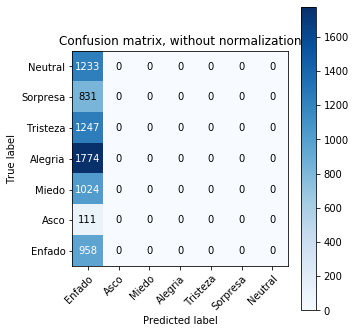

In [20]:
model.load_weights('.anet_0.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [18]:
model = Sequential()

model.add(Conv2D(48,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(class_num, activation='softmax' ))
model.summary()

optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 48, 48, 48)        1248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 128)       153728    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 192)       221376    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 128)      

In [19]:
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mc = ModelCheckpoint('.anet_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

np.random.seed(17)
cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 1141s 3s/step - loss: 1.8157 - accuracy: 0.2517 - val_loss: 1.7209 - val_accuracy: 0.3064 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 392s 872ms/step - loss: 1.6037 - accuracy: 0.3673 - val_loss: 1.5478 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 388s 864ms/step - loss: 1.4726 - accuracy: 0.4270 - val_loss: 1.4273 - val_accuracy: 0.4451 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 384s 856ms/step - loss: 1.3836 - accuracy: 0.4665 - val_loss: 1.4067 - val_accuracy: 0.4471 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 377s 839ms/step - loss: 1.2944 - accuracy: 0.5053 - val_loss: 1.3480 - val_accuracy: 0.4809 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 377s 840ms/step - loss: 1.2031 - accuracy: 0.5414 - val_loss: 1.2895 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 7/100
449/449 [=====================

Confusion matrix
[[ 826    0    5   61    7   27   32]
 [  99    4    0    5    1    2    0]
 [ 815    0   34   48    7   98   22]
 [ 520    0    2 1175    5   47   25]
 [1037    0    5   81   45   20   59]
 [ 266    0    3   41    1  512    8]
 [ 876    0    2   78    6   33  238]]
              precision    recall  f1-score   support

      Enfado       0.19      0.86      0.31       958
        Asco       1.00      0.04      0.07       111
       Miedo       0.67      0.03      0.06      1024
     Alegria       0.79      0.66      0.72      1774
    Tristeza       0.62      0.04      0.07      1247
    Sorpresa       0.69      0.62      0.65       831
     Neutral       0.62      0.19      0.29      1233

    accuracy                           0.39      7178
   macro avg       0.65      0.35      0.31      7178
weighted avg       0.63      0.39      0.37      7178



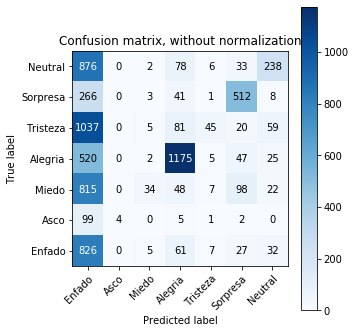

In [21]:
model.load_weights('.anet_1.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [8]:
model = Sequential()

model.add(Conv2D(48,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(class_num, activation='softmax' ))
model.summary()

optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 48)        1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 192)       221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       2

In [ ]:
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mc = ModelCheckpoint('.anet_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

np.random.seed(17)
cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Epoch 1/100
449/449 [==============================] - 2492s 6s/step - loss: 1.8165 - accuracy: 0.2487 - val_loss: 1.8233 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 2249s 5s/step - loss: 1.8126 - accuracy: 0.2513 - val_loss: 1.8155 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 1879s 4s/step - loss: 1.8110 - accuracy: 0.2513 - val_loss: 1.8137 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 1492s 3s/step - loss: 1.8113 - accuracy: 0.2513 - val_loss: 1.8144 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 1148s 3s/step - loss: 1.8110 - accuracy: 0.2513 - val_loss: 1.8156 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 962s 2s/step - loss: 1.8112 - accuracy: 0.2513 - val_loss: 1.8137 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 7/100
449/449 [==============================] 

In [ ]:
model.load_weights('.anet_2.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))


In [ ]:
model = Sequential()

model.add(Conv2D(48,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(5,5),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2D(192,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),input_shape=X_train.shape[1:],padding = 'same', strides = 1, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax' ))
model.summary()

optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
mc = ModelCheckpoint('.anet_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

In [ ]:
model.load_weights('.anet_3.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))


In [ ]:
X_train, X_test, Y_train, Y_test= loadData(filename)
X_train = X_train.reshape(N_train, 48, 48)

In [ ]:
def mirror(img):
    copy = img.copy()
    indx = range(copy.shape[1]-1, -1, -1)
    copy = np.flip(copy, axis = 1)
    return copy


def random_erasing(img):
    copy = img.copy()
    numero_parches=(randint(1,3))
    for i in range(numero_parches):
        tam_h = randint(5,15)
        tam_v = randint(5,15)   
        start_h = randint(0,copy.shape[1]-tam_h)
        start_v = randint(0,copy.shape[0]-tam_v) 
        for i in range(tam_v):
            for j in range(tam_h):
                copy[start_v+i, start_h+j] = 1
    return copy


def tras_x(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[1]- tras))
    copy = img[:,order]
    return copy


def tras_y(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[0]- tras))
    copy = img[order,:]
    return copy

In [ ]:
nuevo = []
etiquetas = []


for i in range(N_train):
    
    if np.random.random() < 0.5:
        n = mirror(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.5:
        if np.random.random() < 0.5:
            n = tras_x(X_train[i],randint(5,15))
        else:
            n = tras_y(X_train[i],randint(5,10))
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.25:
        n = random_erasing(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        

    
    
if len(etiquetas) > 0: 
    nuevo = np.array(nuevo)
    etiquetas =  np.array(etiquetas)
    X_train= np.append(X_train,nuevo,axis=0)
    Y_train = np.append(Y_train, etiquetas)

In [ ]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]